In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from functools import partial

### Import MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

In [4]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### set parameters

In [5]:
learning_rate = 0.001

training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28
n_hidden_1 = 256
n_hidden_2 = 128

# log directory for tensorboard
log_dir = '/tmp/tensorflow/AE_MNIST/logs'

In [6]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [7]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0005):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [8]:
def encoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

### encoder部

In [9]:
def decoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_input, name='decoder_2', activation=None)
    return layer_2

### 二乗和誤差を用いてロス値を計算する方法

In [10]:
"""
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    cost = tf.reduce_mean(tf.square(y_true - y_pred))
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"""

"\n# Construct model\nwith tf.name_scope('encoder_part'):\n    encoder_op = encoder(X)\n\nwith tf.name_scope('decoder_part'):\n    decoder_op = decoder(encoder_op)\n\n# Prediction\nwith tf.name_scope('prediction'):\n    y_pred = decoder_op\n\n# Targets (Labels) are the input data.\nwith tf.name_scope('target'):\n    y_true = X\n\n# Define loss and optimizer, minimize the squared error\nwith tf.name_scope('reduce_mean'):\n    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))\n    cost = tf.reduce_mean(tf.square(y_true - y_pred))\ntf.summary.scalar('reduce_mean', cost)\n\n\nwith tf.name_scope('train'):\n    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)\n"

### シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

In [11]:
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    cost = tf.reduce_mean(loss)
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


### Training

Epoch: 0001 cost= 0.103171252
Epoch: 0002 cost= 0.087123841
Epoch: 0003 cost= 0.080013812
Epoch: 0004 cost= 0.076250099
Epoch: 0005 cost= 0.075279400
Epoch: 0006 cost= 0.071497485
Epoch: 0007 cost= 0.072743244
Epoch: 0008 cost= 0.072626583
Epoch: 0009 cost= 0.072250836
Epoch: 0010 cost= 0.070428774
Optimization Finished!


/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


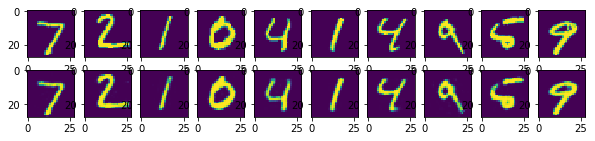

In [12]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

    # Applying encode and decode over test set
    encode_decode = sess.run(y_pred,
                             feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()

sess.close()

## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

In [13]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [14]:
n_data = 10000

#init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    batch_xs, batch_ys = mnist.test.next_batch(n_data)
    hidden = sess.run(encoder_op, feed_dict={X: batch_xs})

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/AE_MNIST/logsmodel/my_model


### メタデータファイルの作成

メタデータファイルは、  
* 最初の行にカラム名を記述  
* メタ情報を2行目以降に記述  

例えば、MNISTの画像のメタデータを作る場合は、以下のように最初のカラムにインデックス、次のカラムにラベル名（数字）を指定します。

In [15]:
# 
#LOG_DIR = "/tmp/tensorflow/tensorboard/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [16]:
"""
ys = batch_ys
with open(os.path.join('./', 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(ys):
        label = int(np.where(label == 1)[0])   ## one-hot to index
        f.write("%d\t%d\n" % (index, label))
"""

'\nys = batch_ys\nwith open(os.path.join(\'./\', \'metadata.tsv\'),\'w\') as f:\n    f.write("Index\tLabel\n")\n    for index, label in enumerate(ys):\n        label = int(np.where(label == 1)[0])   ## one-hot to index\n        f.write("%d\t%d\n" % (index, label))\n'

In [17]:
ys = batch_ys
with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for index, label in enumerate(ys):
        label = int(np.where(label == 1)[0])   ## one-hot to index
        f.write('{}\n'.format(label))


### クラスタ用のembeddingを保存

In [20]:
xs = tf.stack(hidden, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Tensorboard 起動

tensorboard --logdir=/tmp/tensorflow/tensorboard